In [65]:

import numpy
import h5py
import os

from scipy.ndimage import gaussian_filter, uniform_filter
from scipy import optimize, stats
from skimage.transform import resize
from skimage import filters, feature
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from matplotlib import pyplot
from tqdm.auto import tqdm

from banditopt import utils
from banditopt.objectives import Objective

class Squirrel(Objective):
    """
    Implements the `Squirrel` objective

    :param method: A `str` of the method used to optimize
    :param normalize: A `bool` wheter to normalize the images
    """
    def __init__(self, method="L-BFGS-B", normalize=False, use_foreground=False):

        self.method = method
        self.bounds = (-numpy.inf, numpy.inf), (-numpy.inf, numpy.inf), (0, numpy.inf)
        self.x0 = (1, 0, 1)
        self.normalize = normalize
        self.select_optimal = numpy.argmin
        self.use_foreground = use_foreground

    def evaluate(self, sted_stack, confocal_init, confocal_end, sted_fg, confocal_fg, *args, **kwargs):
        """
        Evaluates the objective

        :param sted_stack: A list of STED images.
        :param confocal_init: A confocal image acquired before the STED stack.
        :param concofal_end: A confocal image acquired after the STED stack.
        :param sted_fg: A background mask of the first STED image in the stack
                        (2d array of bool: True on foreground, False on background).
        :param confocal_fg: A background mask of the initial confocal image
                            (2d array of bool: True on foreground, False on background).
        """
        # Optimize
        if not numpy.any(sted_stack[0]):
            return 1.0
#             return mean_squared_error(confocal_init[confocal_fg], sted_stack[0][confocal_fg], squared=True)
        # Optimize
        result = self.optimize(sted_stack[0], confocal_init)
        if self.use_foreground:
            return self.out_squirrel(result.x, sted_stack[0], confocal_init, confocal_fg=confocal_fg)
        else:
            return self.out_squirrel(result.x, sted_stack[0], confocal_init)

    def squirrel(self, x, *args, **kwargs):
        """
        Computes the reconstruction error between
        """
        alpha, beta, sigma = x
        super_resolution, reference = args
        confocal_fg = kwargs.get("confocal_fg", numpy.ones_like(super_resolution, dtype=bool))
        
        non_zero = super_resolution != 0.
        _super_resolution = super_resolution.copy()
        _super_resolution[non_zero] = reference[non_zero]        
        
        convolved = self.convolve(_super_resolution, alpha, beta, sigma)
        if self.normalize:
            reference = (reference - reference.min()) / (reference.max() - reference.min() + 1e-9)
            convolved = (convolved - convolved.min()) / (convolved.max() - convolved.min() + 1e-9)
        error = mean_squared_error(reference[confocal_fg], convolved[confocal_fg], squared=True)
#         error = numpy.quantile(numpy.abs(reference[confocal_fg] - convolved[confocal_fg]), [0.95]).item()
#         error = numpy.mean((reference[confocal_fg] - convolved[confocal_fg]))
        return error
    
    def out_squirrel(self, x, *args, **kwargs):
        """
        Computes the reconstruction error between
        """
#         # SSIM
#         alpha, beta, sigma = x
#         super_resolution, reference = args
#         confocal_fg = kwargs.get("confocal_fg", numpy.ones_like(super_resolution, dtype=bool))
#         convolved = self.convolve(super_resolution, alpha, beta, sigma)
#         if self.normalize:
#             reference = (reference - reference.min()) / (reference.max() - reference.min() + 1e-9)
#             convolved = (convolved - convolved.min()) / (convolved.max() - convolved.min() + 1e-9)
# #         error = numpy.mean(numpy.abs(reference[confocal_fg] - convolved[confocal_fg]))
# #         error = numpy.std(numpy.abs(reference[confocal_fg] - convolved[confocal_fg]))
#         error = structural_similarity(reference, convolved)
#         return 1 - error
        
        # Canny
        alpha, beta, sigma = x
        super_resolution, reference = args
        confocal_fg = kwargs.get("confocal_fg", numpy.ones_like(super_resolution, dtype=bool))
        
        non_zero = super_resolution != 0.
        _super_resolution = super_resolution.copy()
        _super_resolution[non_zero] = reference[non_zero]
        
        convolved = self.convolve(_super_resolution, alpha, beta, sigma)
        if self.normalize:
            reference = (reference - reference.min()) / (reference.max() - reference.min() + 1e-9)
            convolved = (convolved - convolved.min()) / (convolved.max() - convolved.min() + 1e-9)
        error = 1 - structural_similarity(reference.astype(numpy.float32), convolved.astype(numpy.float32)) 
#         S = structure_ssim(reference, convolved)
#         error = mean_squared_error(reference[confocal_fg], convolved[confocal_fg], squared=True)
#         error, _ = stats.pearsonr(reference.astype(numpy.float32).ravel(), convolved.astype(numpy.float32).ravel()) 
            
#         fg_convolved = convolved > filters.threshold_triangle(convolved)
#         fg_reference = reference > filters.threshold_triangle(reference)        
#         error = (fg_convolved * fg_reference).sum() / ((fg_convolved + fg_reference).sum() + 1.0)
#         error = structural_similarity(fg_convolved, fg_reference) 

#         error = 1 - numpy.mean(S * fg_reference)
        
        fig, axes = pyplot.subplots(1, 2)
        axes[0].set_title(error)
        axes[0].imshow(reference)
        axes[1].imshow(convolved)    
#         axes[2].imshow(S)            
        pyplot.show()
        
        return error 

    def optimize(self, super_resolution, reference):
        """
        Optimizes the SQUIRREL parameters

        :param super_resolution: A `numpy.ndarray` of the super-resolution image
        :param reference: A `numpy.ndarray` of the reference image

        :returns : An `OptimizedResult`
        """
        result = optimize.minimize(
            self.squirrel, self.x0, args=(super_resolution, reference),
            method="L-BFGS-B", bounds=(self.bounds)
        )
        return result

    def convolve(self, img, alpha, beta, sigma):
        """
        Convolves an image with the given parameters
        """
        return gaussian_filter(img * alpha + beta, sigma=sigma)

def structure_ssim(im1, im2):
    win_size = 7
    ndim = im1.ndim
    data_range = None
    K1 = 0.01
    K2 = 0.03
    sigma = 1.5
    
    if data_range is None:
        if im1.dtype != im2.dtype:
            warn("Inputs have mismatched dtype.  Setting data_range based on "
                 "im1.dtype.", stacklevel=2)
        dmin, dmax = dtype_range[im1.dtype.type]
        data_range = dmax - dmin    
    
    filter_func = uniform_filter
    filter_args = {'size': win_size}

    # ndimage filters need floating point data
    im1 = im1.astype(numpy.float32, copy=False)
    im2 = im2.astype(numpy.float32, copy=False)

    NP = win_size ** ndim

    # filter has already normalized by NP
    cov_norm = NP / (NP - 1)  # sample covariance

    # compute (weighted) means
    ux = filter_func(im1, **filter_args)
    uy = filter_func(im2, **filter_args)

    # compute (weighted) variances and covariances
    uxx = filter_func(im1 * im1, **filter_args)
    uyy = filter_func(im2 * im2, **filter_args)
    uxy = filter_func(im1 * im2, **filter_args)
    vx = cov_norm * (uxx - ux * ux)
    vy = cov_norm * (uyy - uy * uy)
    vxy = cov_norm * (uxy - ux * uy)

    R = data_range
    C1 = (K1 * R) ** 2
    C2 = (K2 * R) ** 2
    
    s = (2 * vxy + C2) / (vx * vy + C2)
    c = (ux * uy + C2) / (ux * uy + C1)

    A1, A2, B1, B2 = ((2 * ux * uy + C1,
                       2 * vxy + C2,
                       ux ** 2 + uy ** 2 + C1,
                       vx + vy + C2))
    D = B1 * B2
    S = (A1 * A2) / D

    # to avoid edge effects will ignore filter radius strip around edges
    pad = (win_size - 1) // 2

    # compute (weighted) mean of ssim. Use float64 for accuracy.
    mssim = crop(S, pad).mean(dtype=np.float64)   
#     struct = crop(s, pad)#.mean(dtype=np.float64)
    struct = s
    return struct
#     return mssim

  0%|          | 0/100 [00:00<?, ?it/s]

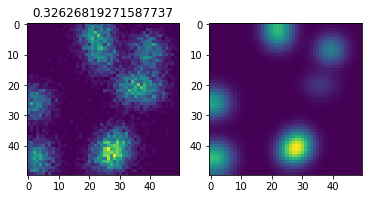

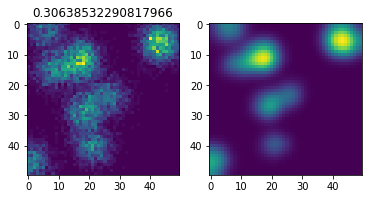

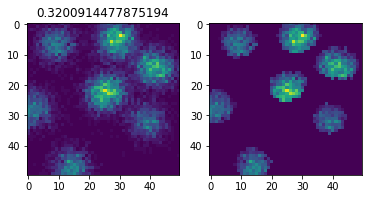

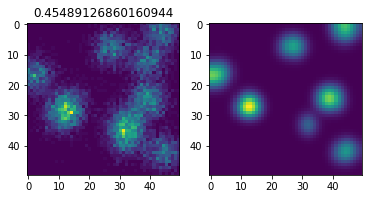

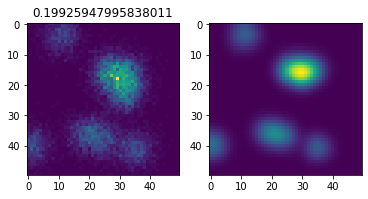

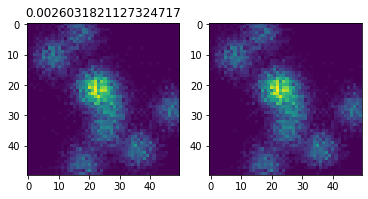

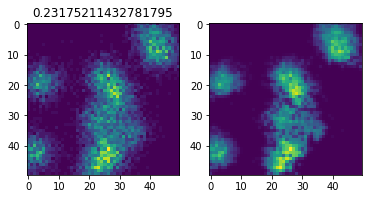

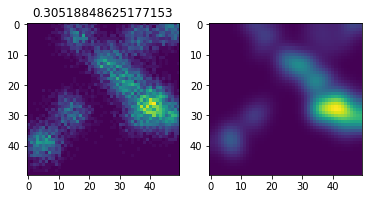

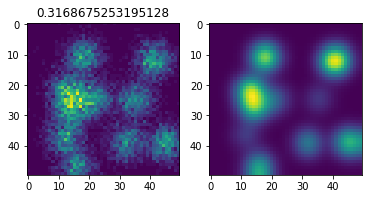

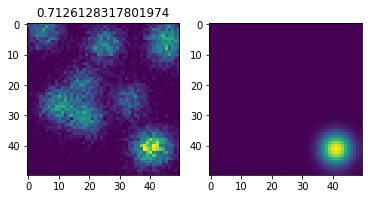

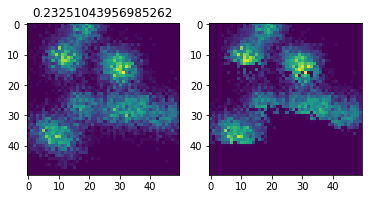

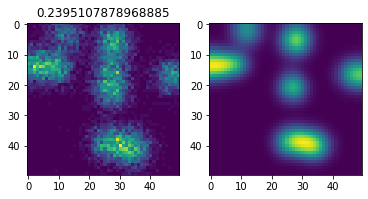

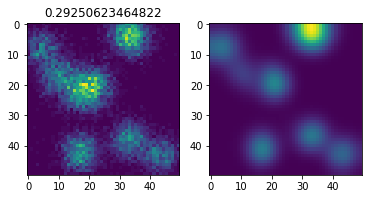

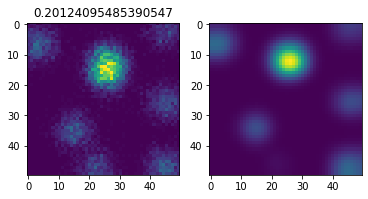

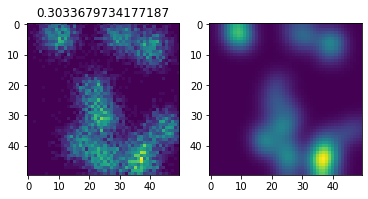

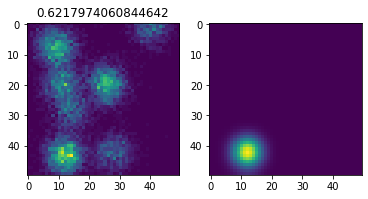

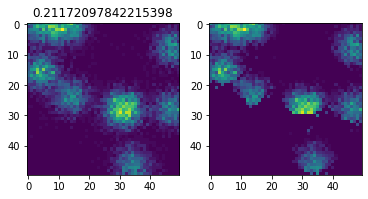

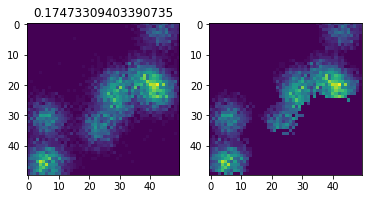

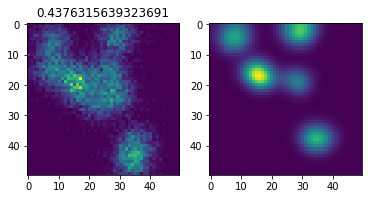

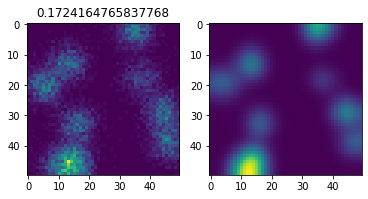

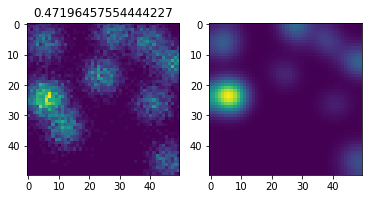

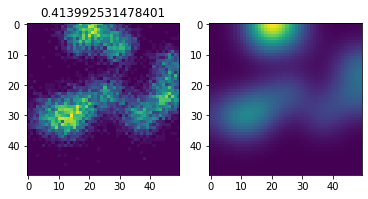

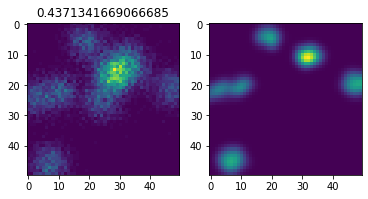

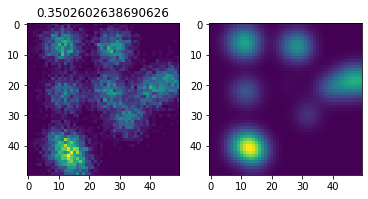

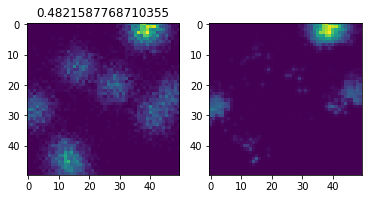

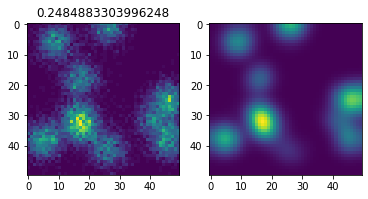

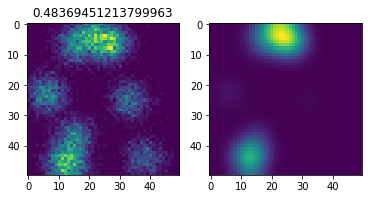

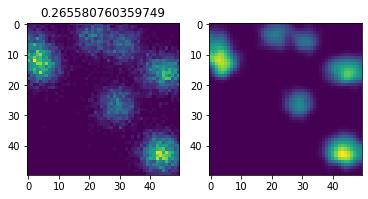

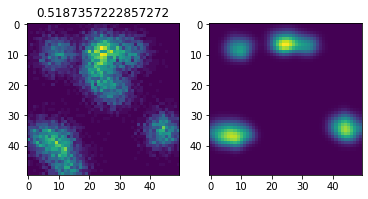

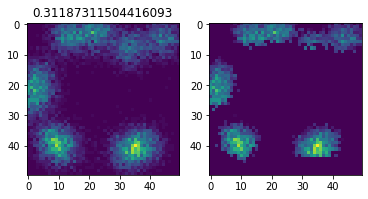

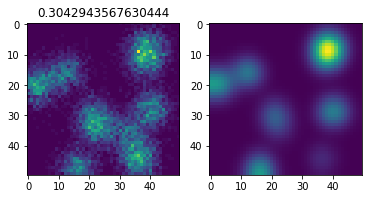

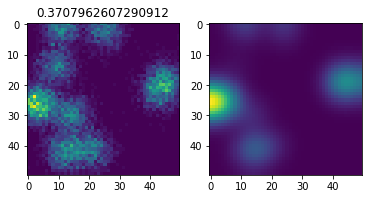

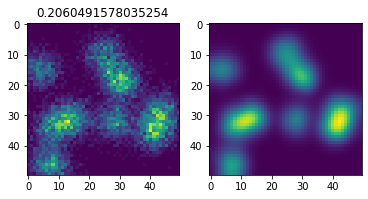

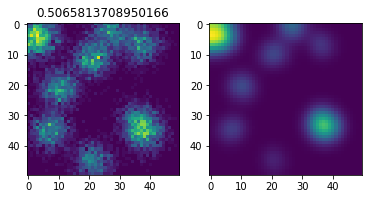

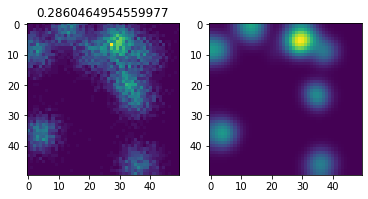

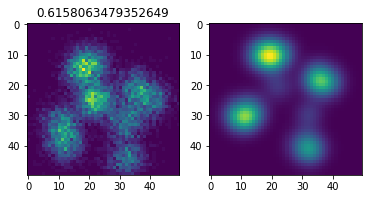

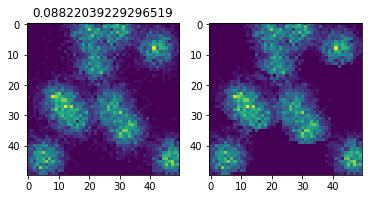

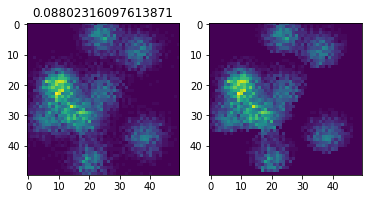

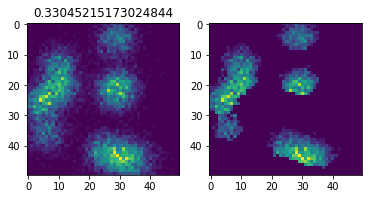

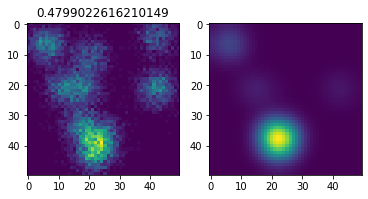

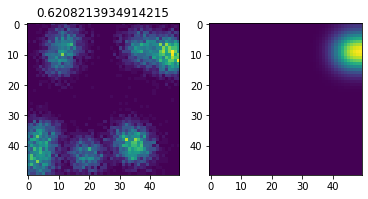

In [66]:
%matplotlib inline

model_names = [
#     "20211124-104652_DyMIN_optim_2params_3objectives_degree3", # 200 time steps - Bayes
#     "20211124-141755_DyMIN_optim_2params_3objectives_degree3", # 200 time steps - Bayes CTX
#     "20211127-093743_DyMIN_optim_2params_3objectives_degree3", # 200 time steps - LinearTS
#     "20211127-135054_DyMIN_optim_2params_3objectives_degreeNone", # 200 time steps - LinearTSDiag    
    "debug"
]
objective = Squirrel(normalize=True, use_foreground=False)

for model_name in model_names:
    with h5py.File(os.path.join("../../data", model_name, "optim.hdf5"), "r") as file:
        sted_images = file["sted"]["0"][()]
        confocal_images = file["conf1"]["0"][()]
        
        squirrels = []
        ssims = []
        for s, c in zip(tqdm(sted_images), confocal_images):
            if not c.any():
                break
            fg = utils.get_foreground(c)
            fg = c > filters.threshold_triangle(c)
            squirrels.append(objective.evaluate([s], c, None, None, fg, use_foreground=False))
            
#             score, _max, _min = wssim(c, s, fg, 3, None, True)
#             ssims.append(score)
            
#             result = objective.optimize(s, c)
#             print(result.x)
            
#             fig, axes = pyplot.subplots(1, 4)
#             axes[0].imshow(c / c.max(), cmap="hot")
#             axes[1].set_title(squirrels[-1])
#             axes[1].imshow(s, cmap="hot")
#             axes[2].imshow(objective.convolve(s, *result.x))
#             axes[3].imshow(fg)
#             pyplot.show()
            

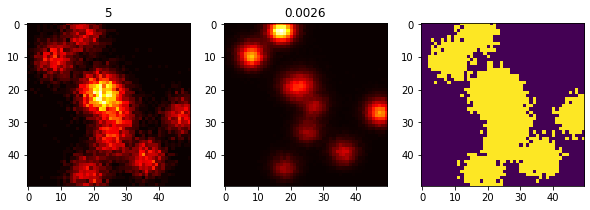

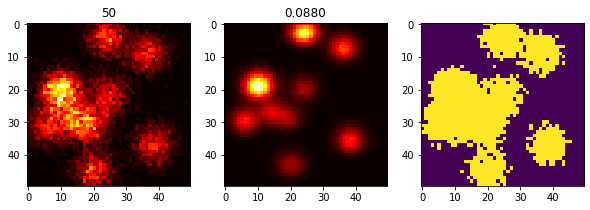

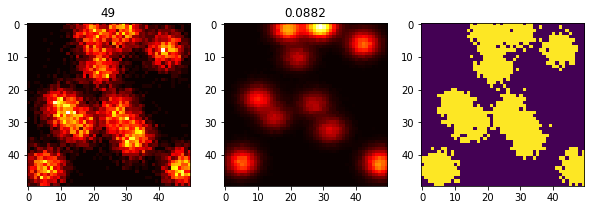

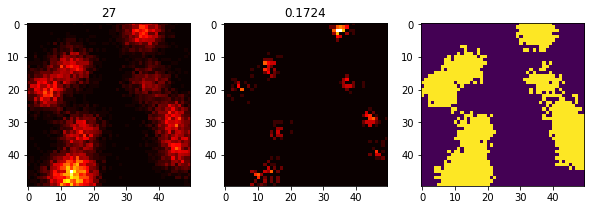

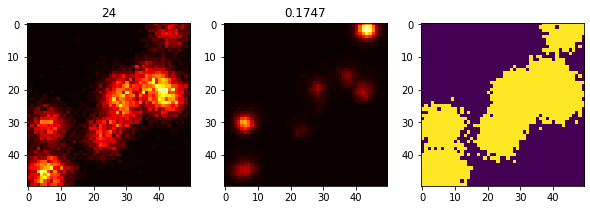

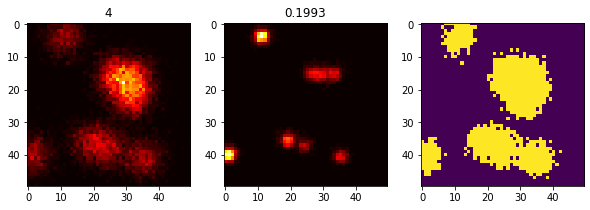

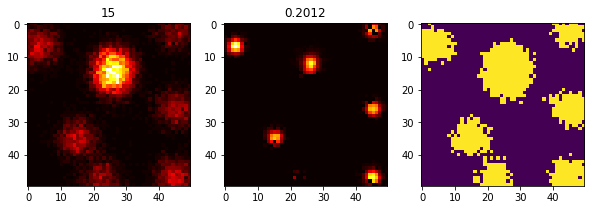

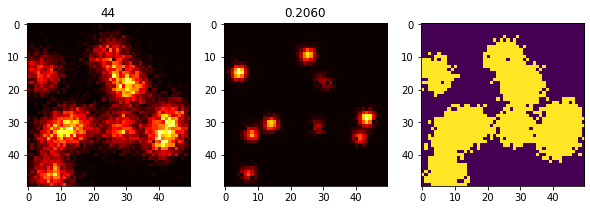

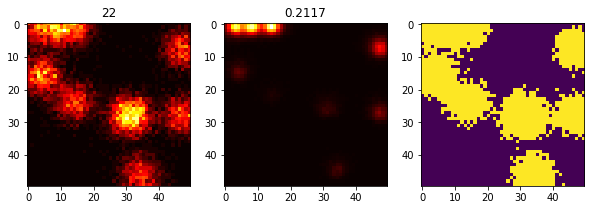

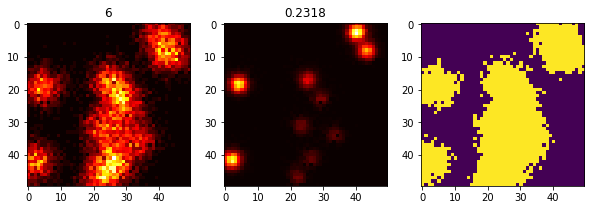

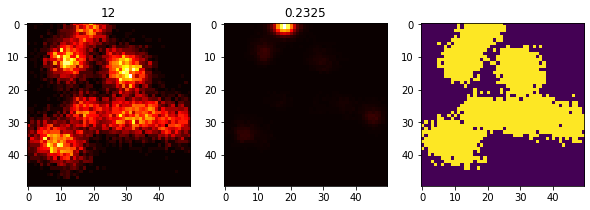

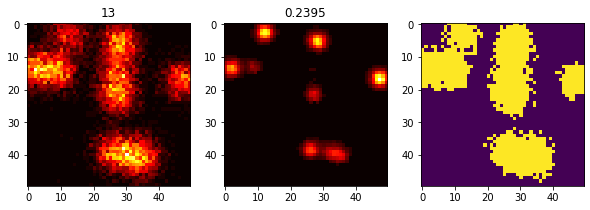

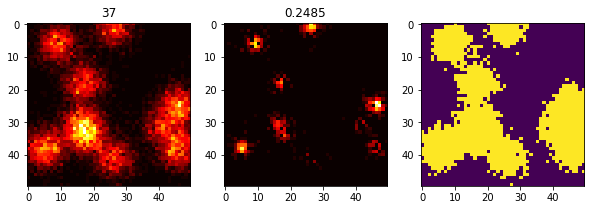

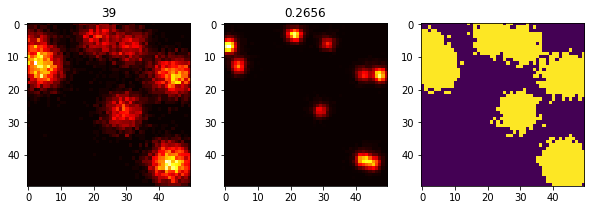

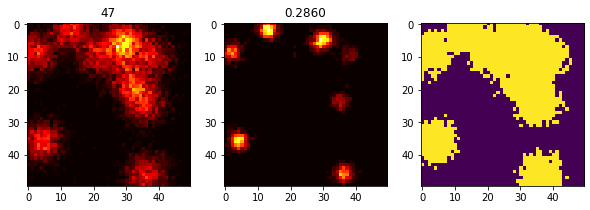

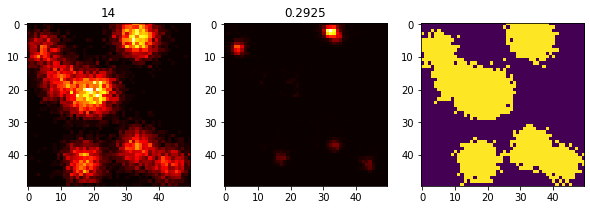

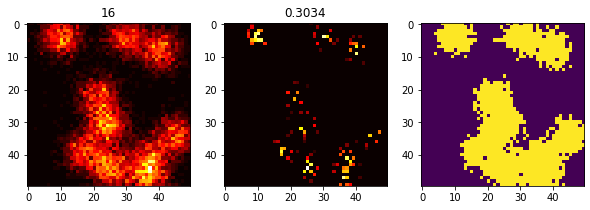

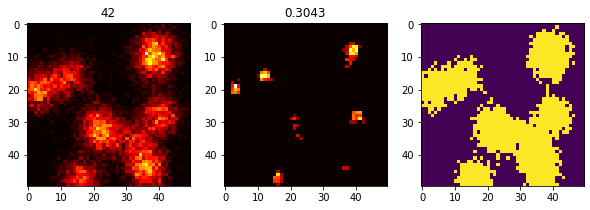

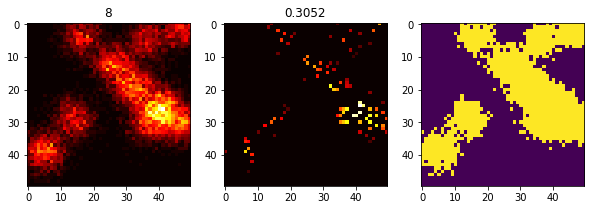

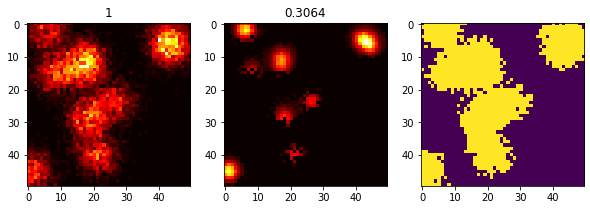

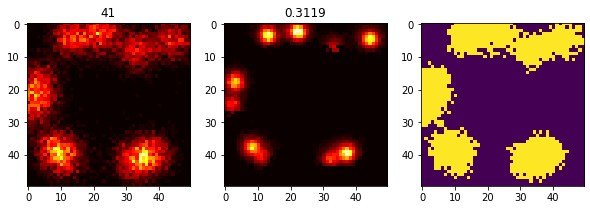

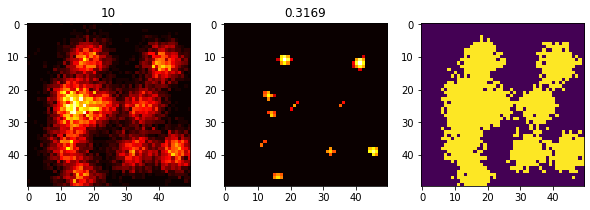

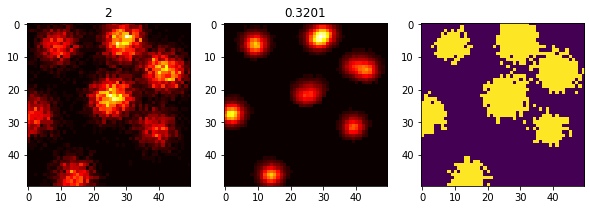

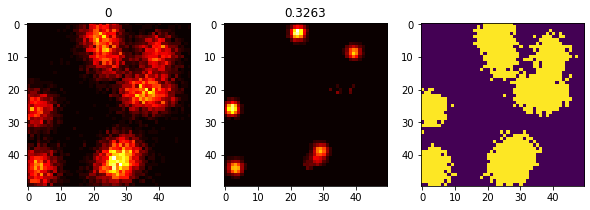

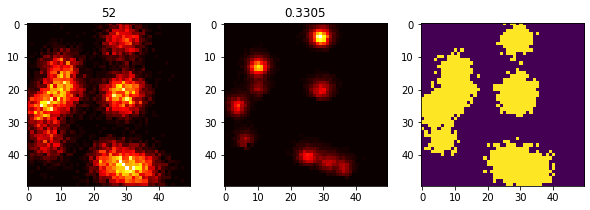

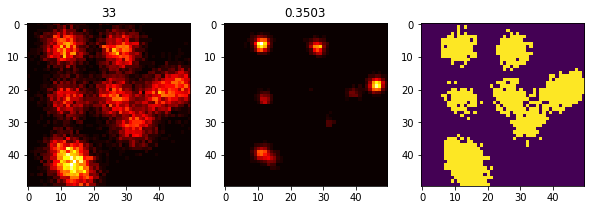

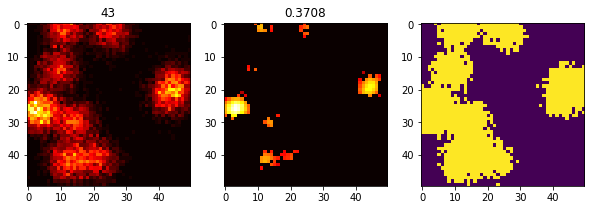

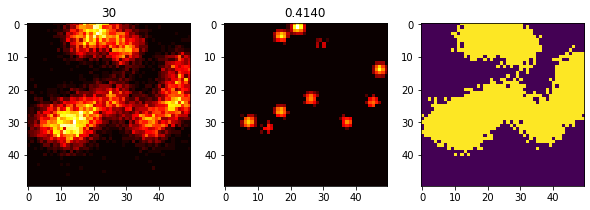

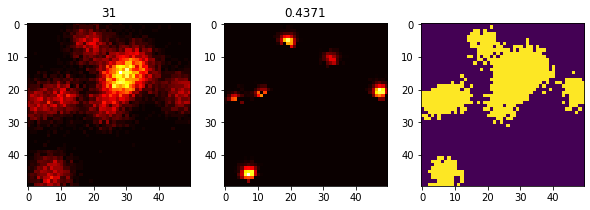

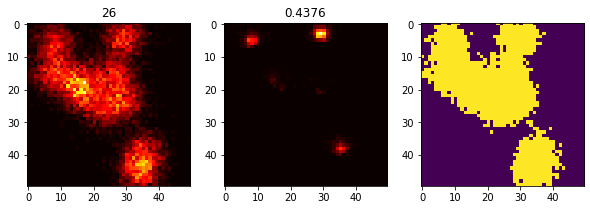

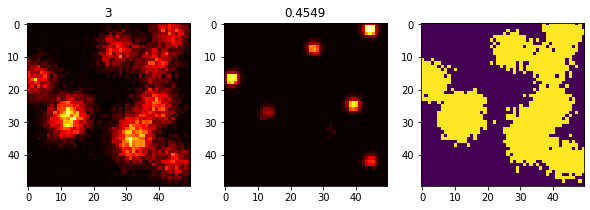

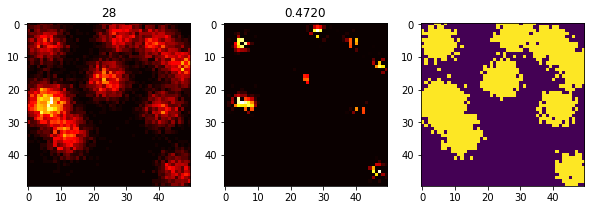

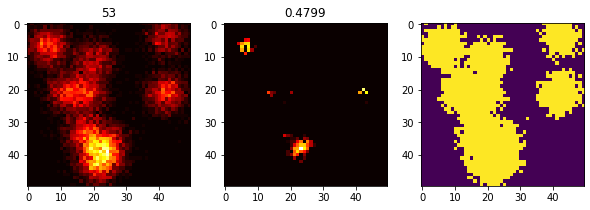

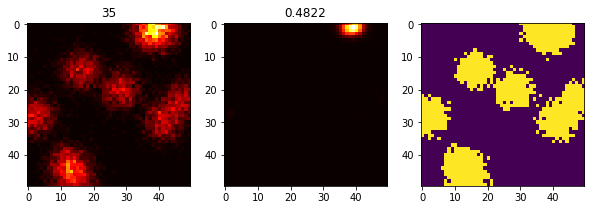

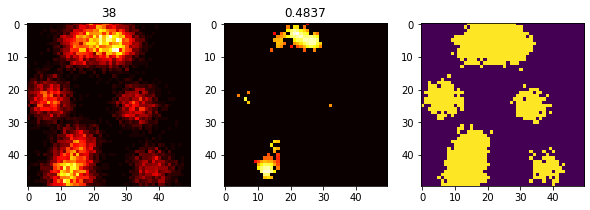

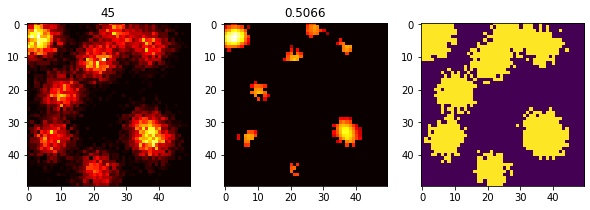

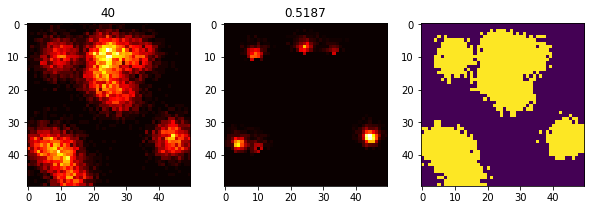

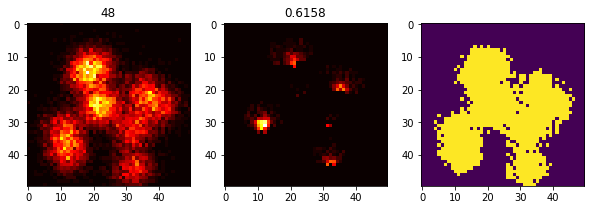

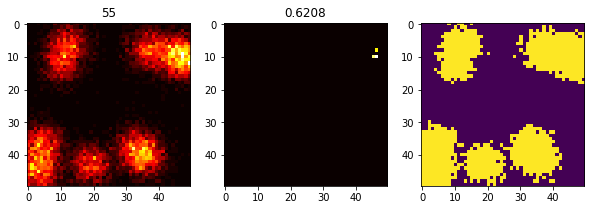

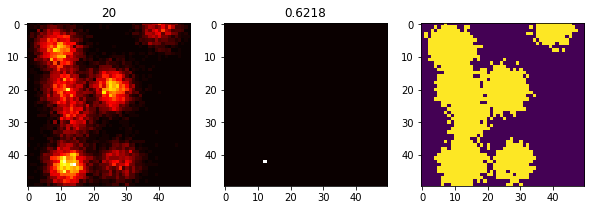

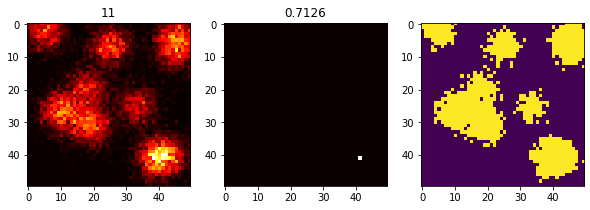

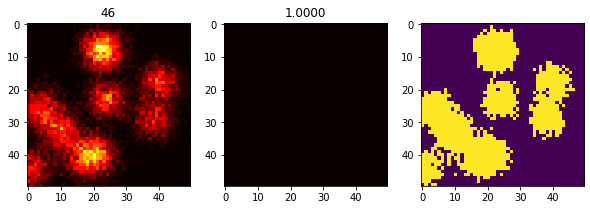

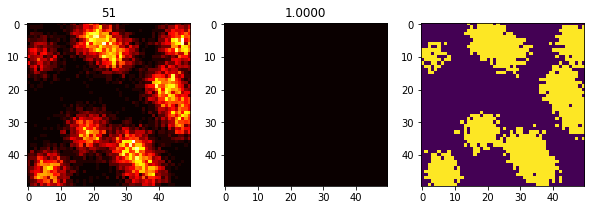

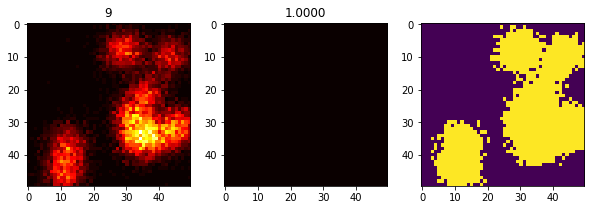

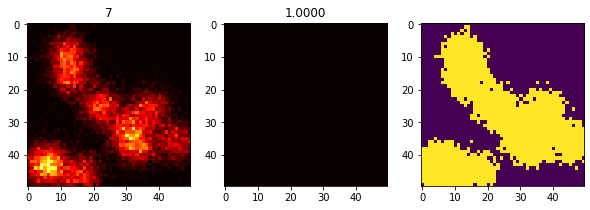

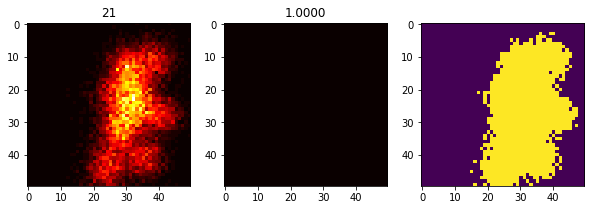

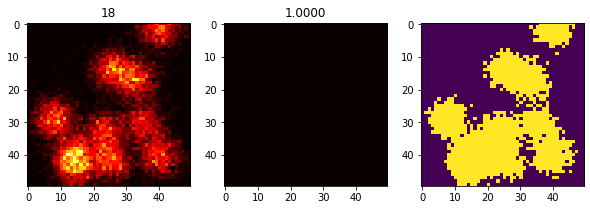

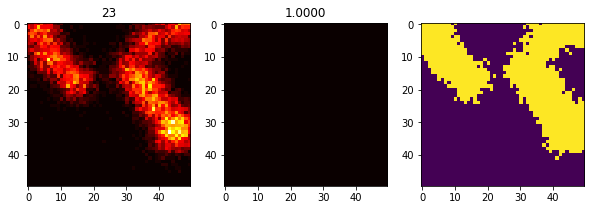

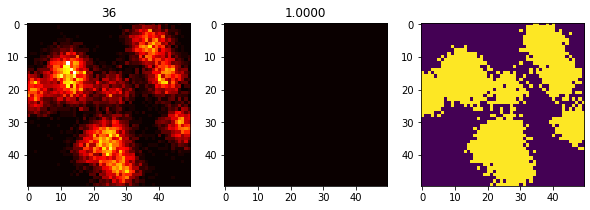

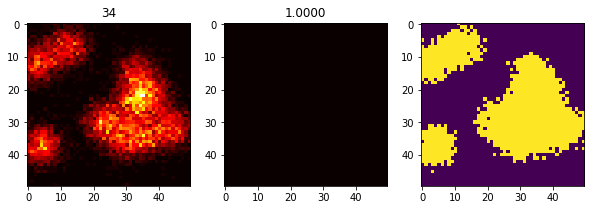

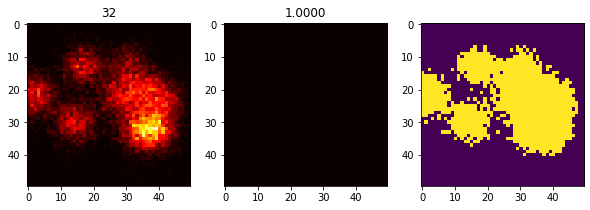

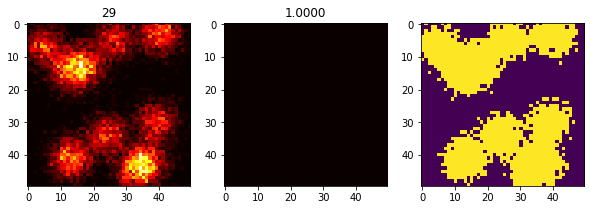

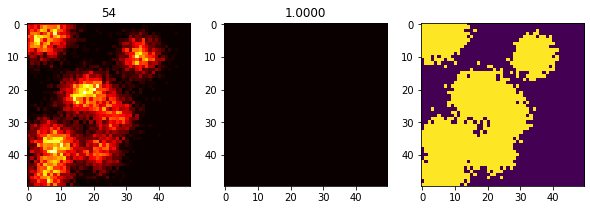

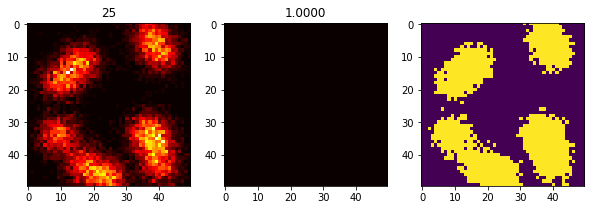

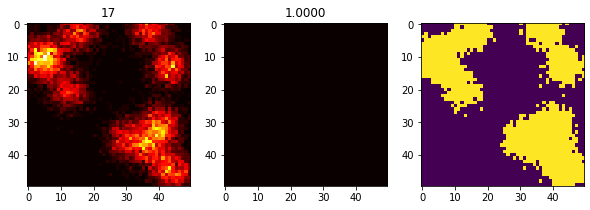

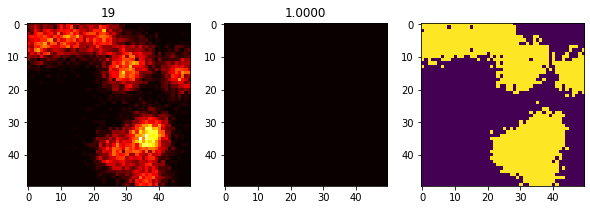

In [67]:
argsorted = numpy.argsort(squirrels)
for index in argsorted[::]: 

    fig, axes = pyplot.subplots(1, 3, figsize=(10, 3))
    axes[0].set_title(index)
    axes[0].imshow(confocal_images[index], cmap="hot")
    axes[1].set_title("{:0.4f}".format(squirrels[index]))
    axes[1].imshow(sted_images[index], cmap="hot", vmin=0, vmax=sted_images[index].max())
    fg = confocal_images[index] > filters.threshold_triangle(confocal_images[index])
    axes[2].imshow(fg)
    pyplot.show()

In [29]:
from PIL import Image
from skimage.metrics import structural_similarity
from skimage.util.dtype import dtype_range
from scipy.ndimage import uniform_filter
from skimage.util.arraycrop import crop
import numpy as np, cv2
from skimage import io
import os.path, math
from skimage import data, img_as_float
import sys, argparse

def wssim(_wf, _csr, _mask, _winsize, figpath, _use_mask):
    K1 = 0.01
    K2 = 0.03
    dmin, dmax = dtype_range[_wf.dtype.type]
    ndim = _wf.ndim
    width, height = _wf.shape
    NP = _winsize ** ndim
    cov_norm = NP / (NP - 1)
    R = dmax - dmin
    C1 = (K1 * R) ** 2
    C2 = (K2 * R) ** 2
    pad = (_winsize - 1) // 2
    wf = _wf.astype(np.float64)
    csr = _csr.astype(np.float64)
    wf_border = cv2.copyMakeBorder(wf, pad, pad, pad, pad, cv2.BORDER_DEFAULT)
    wf_border = wf_border.astype(np.float64)
    csr_border = cv2.copyMakeBorder(csr, pad, pad, pad, pad, cv2.BORDER_DEFAULT)
    csr_border = csr_border.astype(np.float64)
    pad_width, pad_height = wf_border.shape
    ux_weight_image = np.zeros((pad_width, pad_height), dtype=(np.float64))
    uy_weight_image = np.zeros((pad_width, pad_height), dtype=(np.float64))
    uxx_weight_image = np.zeros((pad_width, pad_height), dtype=(np.float64))
    uyy_weight_image = np.zeros((pad_width, pad_height), dtype=(np.float64))
    uxy_weight_image = np.zeros((pad_width, pad_height), dtype=(np.float64))
    if _use_mask:
        mask = _mask.astype(np.float64)
        mask_border = cv2.copyMakeBorder(mask, pad, pad, pad, pad, cv2.BORDER_DEFAULT)
    else:
        mask = np.ones((width, height), dtype=(np.float))
        mask_border = cv2.copyMakeBorder(mask, pad, pad, pad, pad, cv2.BORDER_DEFAULT)
    mask_border = mask_border.astype(np.float64)
    for i in range(pad, pad_width - pad - 1):
        for j in range(pad, pad_height - pad - 1):
            kernel = mask_border[i - pad:i + pad + 1, j - pad:j + pad + 1]
            wf_roi = wf_border[i - pad:i + pad + 1, j - pad:j + pad + 1]
            csr_roi = csr_border[i - pad:i + pad + 1, j - pad:j + pad + 1]
            if np.array(kernel).sum() == 0:
                continue
            else:
                ux_weight_image[(i, j)] = np.average(wf_roi, weights=kernel)
                uy_weight_image[(i, j)] = np.average(csr_roi, weights=kernel)
                uxx_weight_image[(i, j)] = np.average((wf_roi * wf_roi), weights=kernel)
                uyy_weight_image[(i, j)] = np.average((csr_roi * csr_roi), weights=kernel)
                uxy_weight_image[(i, j)] = np.average((wf_roi * csr_roi), weights=kernel)
                if math.isnan(ux_weight_image[(i, j)]) or math.isnan(uy_weight_image[(i, j)]) or math.isnan(uy_weight_image[(i, j)]) or math.isnan(uyy_weight_image[(i, j)]) or math.isnan(uxy_weight_image[(i, j)]):
                    print(i, j)

    vx_weight_image = cov_norm * (uxx_weight_image - ux_weight_image * ux_weight_image)
    vy_weight_image = cov_norm * (uyy_weight_image - uy_weight_image * uy_weight_image)
    vxy_weight_image = cov_norm * (uxy_weight_image - ux_weight_image * uy_weight_image)
    new_A1, new_A2, new_B1, new_B2 = (
     2 * ux_weight_image * uy_weight_image + C1,
     2 * vxy_weight_image + C2,
     ux_weight_image ** 2 + uy_weight_image ** 2 + C1,
     vx_weight_image + vy_weight_image + C2)
    contr_struc_weight = new_A2 / new_B2
    contr_struc_weight = np.maximum(contr_struc_weight, 0)
    contr_struc_score = np.nanmean(crop(contr_struc_weight, pad))
    return (
     contr_struc_score, crop(contr_struc_weight, pad),
     (
      np.max(contr_struc_weight), np.min(contr_struc_weight)))

wf = confocal_images[0]
csr = sted_images[0]
fg = wf > filters.threshold_triangle(wf)

score, _max, _min = wssim(wf, csr, fg, 3, None, False)

ModuleNotFoundError: No module named 'cv2'